## Loading Data 

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

import unicodedata
import string

import torch
from torch import nn

In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/English.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Polish.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Czech.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii(u'Málaga'))

Slusarski
Malaga


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
print (all_categories)

['Portuguese', 'Russian', 'Dutch', 'Arabic', 'English', 'Japanese', 'Irish', 'Polish', 'Greek', 'German', 'Scottish', 'Chinese', 'Spanish', 'French', 'Korean', 'Italian', 'Vietnamese', 'Czech']


In [6]:
print(category_lines['Arabic'][200:215])

['Ganim', 'Sleiman', 'Seif', 'Moghadam', 'Ba', 'Tannous', 'Bazzi', 'Seif', 'Salib', 'Hadad', 'Quraishi', 'Halabi', 'Essa', 'Bahar', 'Kattan']


In [7]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

## Turning Names into Tensors

In [8]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# print(letterToTensor('J'))
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


## Model

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        # output = self.softmax(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).cuda()

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).cuda()

In [49]:
input = lineToTensor('Binu').cuda()
hidden = torch.zeros(1, n_hidden).cuda()

output, next_hidden = rnn(input[2], hidden)
print(output)

tensor([[-2.8644, -2.9622, -2.9527, -2.8371, -2.7764, -2.8919, -2.8751,
         -2.9322, -2.9344, -2.9793, -2.8260, -2.8937, -2.8118, -2.7689,
         -2.9079, -2.9534, -2.9683, -2.9286]], device='cuda:0')


In [9]:
def categoryFromOutput(output):
    # top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    # category_i = top_i[0][0]
    val, ind = torch.max(output, 1)
    category_i = int(ind)
    return all_categories[category_i], category_i

In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.LongTensor([all_categories.index(category)]).cuda()
    line_tensor = lineToTensor(line).cuda()
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Uemura
category = Dutch / line = Romijn
category = Irish / line = Bran
category = Spanish / line = Robledo
category = Polish / line = Mozdzierz
category = Russian / line = Avdiysky
category = Irish / line = Mathghamhain
category = Scottish / line = Burns
category = Polish / line = Kozlowski
category = Portuguese / line = Palmeiro


In [11]:
criterion = nn.NLLLoss()

## Train

In [24]:
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [25]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.8229 Muirchertach / German ✗ (Irish)
10000 10% (0m 13s) 2.7862 Costa / Japanese ✗ (Spanish)
15000 15% (0m 20s) 2.7913 Shao / Portuguese ✗ (Chinese)
20000 20% (0m 27s) 2.5808 Nunes / Greek ✗ (Portuguese)
25000 25% (0m 34s) 2.0489 Kyritsis / Greek ✓
30000 30% (0m 41s) 2.6978 Nifterik / Italian ✗ (Dutch)
35000 35% (0m 48s) 2.5325 Cuoco / Arabic ✗ (Italian)
40000 40% (0m 55s) 3.2544 Kokkali / Italian ✗ (Greek)
45000 45% (1m 2s) 3.0873 Ii / Korean ✗ (Japanese)
50000 50% (1m 9s) 2.6321 Gerald / German ✗ (Irish)
55000 55% (1m 16s) 3.0320 Rootham / Russian ✗ (English)
60000 60% (1m 23s) 1.9337 Pinheiro / Italian ✗ (Portuguese)
65000 65% (1m 30s) 2.0953 Romao / Portuguese ✓
70000 70% (1m 37s) 1.1440 Tieu / Vietnamese ✓
75000 75% (1m 44s) 1.6254 Glockl / Polish ✗ (Czech)
80000 80% (1m 51s) 2.7952 Wallace / Irish ✗ (Scottish)
85000 85% (1m 58s) 4.5482 King / Chinese ✗ (Scottish)
90000 90% (2m 5s) 2.9307 Bonnay / Irish ✗ (French)
95000 95% (2m 11s) 1.8305 Manco / Portuguese ✗ (It

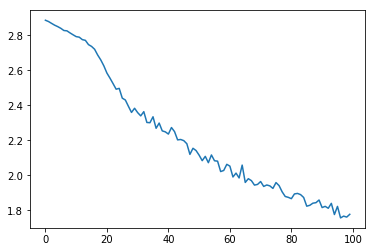

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate

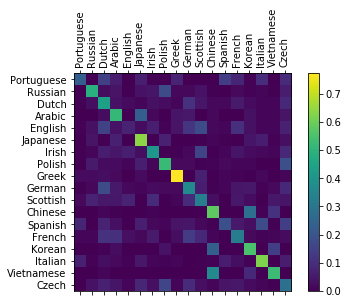

In [27]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Use GRU

In [106]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        
        self.h0 = torch.randn(1, 1, hidden_size).cuda()
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inp):
        # inp.shape = [seql, 1, n_letters], h0.shape = [1, 1, hidden_size]
        output, h = self.gru(inp, self.h0) # output.shape = [seql, 1, hidden_size]
        h = h.contiguous()
        h = h.view(-1, output.shape[2])
        h = self.fc(h)
        return F.log_softmax(h, dim=1)

In [107]:
n_hidden = 128
model = Encoder(n_letters, n_hidden, n_categories).cuda()

In [108]:
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [109]:
inp = lineToTensor('Binu').cuda()
output = model(inp)
output

tensor([[-2.8460, -2.9825, -2.8805, -2.8982, -2.8981, -2.8994, -2.8480,
         -2.8506, -3.0594, -2.8725, -2.9130, -2.8792, -2.8269, -2.9014,
         -2.9174, -2.8597, -2.7817, -2.9437]], device='cuda:0')

## Train

In [111]:
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    output = model(line_tensor)
    output = output.view(1, n_categories)
    loss = criterion(output, category_tensor)
    # clear previous gradients, compute gradients of all variables wrt loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [112]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
model.train()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 5.0331 Ibu / Korean ✗ (Japanese)
10000 10% (0m 11s) 1.2184 Andrysiak / Polish ✓
15000 15% (0m 16s) 1.6698 Hanania / Japanese ✗ (Arabic)
20000 20% (0m 22s) 1.8260 Valencia / Italian ✗ (Spanish)
25000 25% (0m 28s) 0.1252 Alcheri / Italian ✓
30000 30% (0m 33s) 1.2526 Sun / Vietnamese ✗ (Korean)
35000 35% (0m 39s) 0.7316 Nowak / Polish ✓
40000 40% (0m 45s) 3.1745 Miazga / Japanese ✗ (Polish)
45000 45% (0m 50s) 1.1534 Lam / Vietnamese ✓
50000 50% (0m 56s) 0.4099 Tsutaya / Japanese ✓
55000 55% (1m 2s) 0.0568 Kuroki / Japanese ✓
60000 60% (1m 7s) 0.3541 Fini / Italian ✓
65000 65% (1m 13s) 1.6059 Vanstein / French ✗ (Russian)
70000 70% (1m 18s) 0.2165 Ribeiro / Portuguese ✓
75000 75% (1m 24s) 0.6128 Harley / English ✓
80000 80% (1m 30s) 1.0138 Gorka / Czech ✗ (Polish)
85000 85% (1m 35s) 0.2281 Dioletis / Greek ✓
90000 90% (1m 41s) 0.1286 Conall / Irish ✓
95000 95% (1m 46s) 0.6522 Delgado / Portuguese ✓
100000 100% (1m 52s) 0.0390 Vu / Vietnamese ✓


In [115]:
# run for another set of iterations
start = time.time()
model.train()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 0.6169 Rosa / Spanish ✓
10000 10% (0m 12s) 1.4223 Hout / French ✗ (Dutch)
15000 15% (0m 19s) 0.0064 Babadjanoff / Russian ✓
20000 20% (0m 25s) 0.0696 Luc / Vietnamese ✓
25000 25% (0m 32s) 0.3696 Yan / Chinese ✓
30000 30% (0m 38s) 0.0095 Abbadelli / Italian ✓
35000 35% (0m 45s) 0.8664 Jenicek / Polish ✗ (Czech)
40000 40% (0m 51s) 0.0117 Boutros / Arabic ✓
45000 45% (0m 57s) 0.0606 Khouri / Arabic ✓
50000 50% (1m 4s) 0.1019 Rossem / Dutch ✓
55000 55% (1m 10s) 0.0035 Parakhin / Russian ✓
60000 60% (1m 17s) 0.0574 Tamazaki / Japanese ✓
65000 65% (1m 23s) 0.1877 Ding / Chinese ✓
70000 70% (1m 29s) 0.0124 Vinh / Vietnamese ✓
75000 75% (1m 36s) 0.0057 Schrijnemakers / Dutch ✓
80000 80% (1m 42s) 0.0175 Said / Arabic ✓
85000 85% (1m 49s) 0.0022 Murchadh / Irish ✓
90000 90% (1m 55s) 0.0169 O'Malley / Irish ✓
95000 95% (2m 1s) 0.4036 Dalach / Irish ✓
100000 100% (2m 8s) 0.1936 Van / Vietnamese ✓


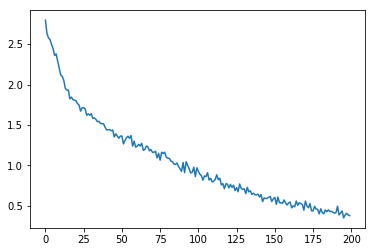

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate

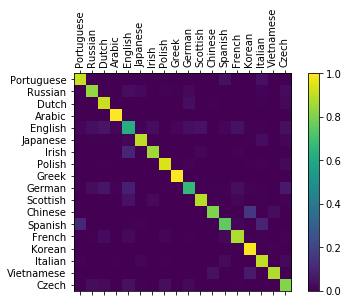

In [117]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):

    output = model(line_tensor)
    output.view(1, n_categories)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()